In [ ]:
# ML_in_Finance-RNNs-Bitcoin
# Author: Matthew Dixon
# Version: 1.1 (27.2.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, statsmodels=0.10.1
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

## An Introduction to Prediction with RNNs

### Overview
- This notebook provides an example of how Keras can be used to train and test TensorFlow RNNs for time series prediction. The example dataset is for predicting from noisy, non-stationary data.
- Statistical methods used for autoregressive models shall be used to identify the sequence length needed in the RNN and to diagnose the model error.
- Plain RNNs are not suited to non-stationary time series modeling. We can use a GRU or LSTM to model non-stationary data, since these models exhibit dynamic auto-correlation structure.
- Unlike classical time series methods, e.g. ARIMA, there are no parametric assumptions on the distribution of the errors, and non-linear relationships between response and predictors can be captured. 
- The data is snapshots of the USD value of Coinbase every minute over 2018.

#### Statistician's note
- We choose to build a model which provides strong predictive power, at the expense of reduced explanatory power. 
- Our choice to use a recurrent neural network is predicated on each observation in the time series being dependent on previous observations. The ordering of the observations therefore matters and $X$ is not iid.
- Once the input data is appropriately scaled, model building starts with 'feature selection' - identifying the relevant features to include in the model. 

- In this notebook, we assume that we've already identifed the relevant set of features (i.e. there is only one time series provided).
- Our primary concern is assessing the extent to which the model is over-fitting, by comparing the in- and out-of-sample MSEs.

#### Implementation notes
- It is important to ensure that `shuffle=False` in the fit function, otherwise the ordering of sequences is not preserved. This is especially important for methods which have memory beyond the current sequence (i.e. all methods except RNNs).
- Time series cross-validation must be used for hyper-parameter tuning because the ordering of the data matters. In particular, the model must never use training data more recent than the forecasting observation date.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from datetime import timedelta

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV

import tensorflow.keras as keras

#from keras import initializers
#from tensorflow.keras.layers import Dense, Layer, LSTM, GRU, SimpleRNN, RNN
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import load_model
#from tensorflow.keras.regularizers import l1, l2
#from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [2]:
%matplotlib inline

### Example Data
- The example dataset $X$ is a chronologically ordered time series. The ordering of the observations matters and each observation is not assumed to be independent (as with cross-sectional classification data). 

- Each observation in $X$ has one variable (a.k.a. univariate time series).

In [3]:
df = pd.read_csv('coinbase.csv', index_col=1)

df.index = pd.to_datetime(df.index, infer_datetime_format=True)

In [4]:
df

,USD
timestamp,
2018-01-01 00:00:00,13598.814422
2018-01-01 00:01:00,13596.912824
2018-01-01 00:02:00,13568.356998
2018-01-01 00:03:00,13560.425182
2018-01-01 00:04:00,13552.270931
...,...
2018-11-10 15:56:00,6347.417225
2018-11-10 15:57:00,6347.419294
2018-11-10 15:58:00,6347.418653


The dataset contains missing values; in order to prevent this causing errors, we replace these with adjacent values from the time series.

In [5]:
nof_missing_values = sum(np.isnan(df['USD']))

print(nof_missing_values, 'observations are missing.')
print('This is {:.3f}% of the total.'.format(nof_missing_values*100/len(df)))

1662 observations are missing.
This is 0.368% of the total.


In [6]:
df = df.fillna(method="backfill")

nof_missing_values = sum(np.isnan(df['USD']))

print('Now', nof_missing_values, 'observations are missing.')

Now 0 observations are missing.


# RNN Regression
We consider a univariate prediction problem where the time series is given by 'USD' in the data frame, and for each input sequence we predict the value 4 time-steps into the future.

In [7]:
use_features = ['USD'] # continuous input
target = ['USD'] # continuous output
n_steps_ahead = 4 # forecasting horizon

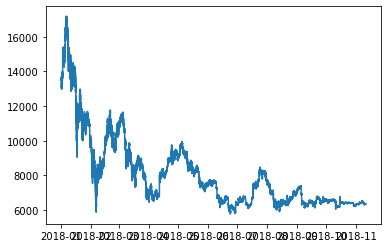

In [8]:
plt.plot(df['USD'])

### Stationarity
It is essential to determine whether the time series is "stationary". Informally, stationarity is when the auto-covariance is independent of time. Failure to establish stationarity will almost certainly lead to misinterpretation of model identification and diagnostic tests. Moreover, stationarity is decisive in characterizing the prediction problem and whether to use a more advanced architecture. In particular, we can expect a plain RNN to perform poorly if the data is non-stationary as the RNN exhibits fixed auto-covariance. 

We perform an Augmented Dickey-Fuller test to establish stationarity under the assumption that the time series has a constant bias but does not exhibit a time trend. In other words, we assume that the time series is already de-trended. 

If the stationarity test fails, even after first de-trending the time series, then one potential recourse is to simply take differences of time series and predict $\Delta y_t$.




The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the p-value is above $(1-\alpha)$, then we cannot reject that there is a unit root. Note that a subset of the time series is used to reduce the memory requirements of the test. We use the first 200,000 samples to test for stationarity. While the test statistic is sensitive to the data size, the ADF test is always accepted at the 99\% level.

In [9]:
sample = df['USD'][:200000]
adf, p, usedlag, nobs, cvs, aic = sm.tsa.stattools.adfuller(sample)

In [10]:
adf_results_string = 'ADF: {}\np-value: {},\nN: {}, \ncritical values: {}'
print(adf_results_string.format(adf, p, nobs, cvs))

ADF: -2.094557163375799
p-value: 0.24670881839393738,
N: 199918, 
critical values: {'1%': -3.4303827103310676, '5%': -2.8615544575334875, '10%': -2.566777695225296}


Here we accept the null as the p-value is larger than 0.01, thus we can not reject the test at the 99% confidence level. This suggests that the time series is **non-stationary**.

#### Autoregressive Model Identification: The partial auto-correlation
It is important to determine the number of lags, the sequence length, required in the RNN by statistical analysis. A brute-force approach will in general be too time-consuming.

A partial auto-correlation at lag $h\geq 2$ is a conditional auto-correlation between a variable, $X_t$, and its $h^{th}$ lag, $X_{t-h}$ under the assumption that we control for the values of the intermediate lags, $X_{t-1},\dots, X_{t-h+1}$:

$$\begin{align}\tau_h&:=\tau(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})\\
&:=\frac{\gamma(X_t, X_{t-h}; X_{t-1},\dots, X_{t-h+1})}{\sqrt{\gamma(X_t |X_{t-1},\dots, X_{t-h+1})\gamma(X_{t-h} |X_{t-1},\dots, X_{t-h+1}))}},
\end{align}$$
where $\gamma_h:=\gamma(X_tX_{t-h})$ is the lag-$h$ autocovariance. The partial autocorrelation function $\tau_h:\mathbb{N} \rightarrow [-1,1]$ is a map $h:\mapsto \tau_h$.

The estimated partial auto-correlation function (PACF) can be used to identify the order of an autoregressive time series model. Values of $|\tau_h|$ greater or equal to $\frac{\Phi^{-1}(\alpha)}{\sqrt{T}}$, where $T$ is the number of observations and $\Phi(z)$ is the standard normal CDF, are significant lag $h$ partial autocorelations at the $\alpha$ confidence level.

We use the stattools package to estimate the PACF. The `nlags` parameter is the maximum number of lags used for PACF estimation.

In [11]:
pacf = sm.tsa.stattools.pacf(df[use_features], nlags=30)

In [12]:
T = len(df[use_features])

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

We find the first lag which isn't significant at the 99% level and automatically determine the number of lags needed in our autoregressive model as one below this value.

In [13]:
for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 4


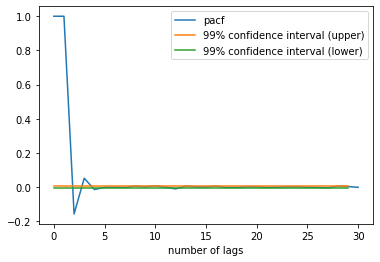

In [14]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

### Splitting the time series into training and testing sets
Split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias. Also, random sampling of the data can not be used as this would eliminate the auto-correlation structure.

In [15]:
train_weight = 0.8
split = int(len(df) * train_weight)

df_train = df[use_features].iloc[:split]
df_test = df[use_features].iloc[split:]

### Scaling
Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [16]:
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
mu = np.float(df_train.mean())
sigma = np.float(df_train.std())

stdize_input = lambda x: (x - mu) / sigma

df_train = df_train.apply(stdize_input)
df_test = df_test.apply(stdize_input)

### Data formatting for RNNs

TensorFlow uses tensors to represent data. To perform sequence learning, the time series of variables must be transformed to a series of over-lapping sub-sequences. 

For example, consider a univariate time series of increasing integers.

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

Setting the sequence length to 10, for example, we move the window forward by one observation at a time and construct new sequences:

1 2 3 4 5 6 7 8 9 10

2 3 4 5 6 7 8 9 10 11

3 4 5 6 7 8 9 10 11 12

4 5 6 7 8 9 10 11 12 13

5 6 7 8 9 10 11 12 13 14

6 7 8 9 10 11 12 13 14 15


Let's define the following function for reshaping the data into one-step ahead times series prediction format. 

In [17]:
def get_lagged_features(df, n_steps, n_steps_ahead):
    """
    df: pandas DataFrame of time series to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    
    for lag in range(n_steps + n_steps_ahead - 1, n_steps_ahead - 1, -1):
        lag_list.append(df.shift(lag))
    lag_array = np.dstack([i[n_steps+n_steps_ahead-1:] for i in lag_list])
    # We swap the last two dimensions so each slice along the first dimension
    # is the same shape as the corresponding segment of the input time series 
    lag_array = np.swapaxes(lag_array, 1, -1)
    return lag_array

We shall first transform the training input and output data.

In [18]:
x_train = get_lagged_features(df_train, n_steps, n_steps_ahead)
y_train =  df_train.values[n_steps + n_steps_ahead - 1:]
y_train_timestamps = df_train.index[n_steps + n_steps_ahead - 1:]

x_test = get_lagged_features(df_test, n_steps, n_steps_ahead)
y_test =  df_test.values[n_steps + n_steps_ahead - 1:]
y_test_timestamps = df_test.index[n_steps + n_steps_ahead - 1:]

In [19]:
print([tensor.shape for tensor in (x_train, y_train, x_test, y_test)])

[(361337, 4, 1), (361337, 1), (90330, 4, 1), (90330, 1)]


### Model Specification


In [20]:
def SimpleRNN_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.SimpleRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True, stateful=False))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def GRU_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.GRU(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True))  
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model


def LSTM_(n_units = 10, l1_reg=0, seed=0):
  model = keras.models.Sequential()
  model.add(keras.layers.LSTM(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=keras.regularizers.l1(l1_reg), input_shape=(x_train.shape[1], x_train.shape[-1]), unroll=True)) 
  model.add(keras.layers.Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

Use a batch size of 1000 as the dataset is reasonably large and the training time would be too long otherwise. 20 epochs have been used here, but a better approach would be to use a stopping criteria through a call back. 

In [21]:
max_epochs = 20 #Dejar mil
batch_size = 1000

In [22]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

In [23]:
params = {
    'rnn': {
        'model': None, 'function': SimpleRNN_, 'l1_reg': 0.0, 'H': 20, 
        'color': 'blue', 'label':'RNN'}, 
    'gru': {
        'model': None, 'function':GRU_,'l1_reg': 0.0, 'H': 10, 
        'color': 'orange', 'label': 'GRU'},
    'lstm': {
        'model': None, 'function': LSTM_,'l1_reg': 0.0, 'H': 10, 
        'color':'red', 'label': 'LSTM'}
}

In [24]:
params

{'rnn': {'model': None,
  'function': <function __main__.SimpleRNN_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 20,
  'color': 'blue',
  'label': 'RNN'},
 'gru': {'model': None,
  'function': <function __main__.GRU_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'orange',
  'label': 'GRU'},
 'lstm': {'model': None,
  'function': <function __main__.LSTM_(n_units=10, l1_reg=0, seed=0)>,
  'l1_reg': 0.0,
  'H': 10,
  'color': 'red',
  'label': 'LSTM'}}

# Optionally, load pre-trained models
Training the models takes several hours. To save time, you may load the already fitted models instead:

In [25]:
do_training = True # Set to True if you wish to train your own models

In [ ]:
#if do_training is False:
#    custom_objects = {'AlphaRNN': AlphaRNN, 'AlphatRNN': AlphatRNN}
#    for key in params.keys():
#        params[key]['model'] = load_model('trained-RNNs/RNNs-Bitcoin-' + key + '.hdf5', custom_objects=custom_objects)

# Cross-validation

The cell below performs a grid search to optimise the `n_units` and `l1_reg` for each of the models using the training data. 

The results are cross-validated to avoid over-fitting. Scikit-Learn's `TimeSeriesSplit` function is used to partition the data into 5 pairs of training and testing sets, where the test data is always ahead of the training data in time. 

In [26]:
cross_val = True # WARNING: Changing this to True will take many hours to run

if do_training and cross_val:
    n_units = [5, 10, 20]
    l1_reg = [0, 0.001, 0.01, 0.1]
    
    # A dictionary containing a list of values to be iterated through
    # for each parameter of the model included in the search
    param_grid = {'n_units': n_units, 'l1_reg': l1_reg}
    
    # In the kth split, TimeSeriesSplit returns first k folds 
    # as training set and the (k+1)th fold as test set.
    tscv = TimeSeriesSplit(n_splits = 5)
    
    # A grid search is performed for each of the models, and the parameter set which
    # performs best over all the cross-validation splits is saved in the `params` dictionary
    for key in params.keys():
        print('Performing cross-validation. Model:', key)
        model = keras.wrappers.scikit_learn.KerasRegressor(build_fn=params[key]['function'], epochs=max_epochs, 
                               batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model, param_grid=param_grid, 
                            cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train, y_train, callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))
            
        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

Performing cross-validation. Model: rnn
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] l1_reg=0, n_units=5 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/20
61/61 - 1s - loss: 0.8776
Epoch 2/20
61/61 - 0s - loss: 0.5659
Epoch 3/20
61/61 - 0s - loss: 0.3976
Epoch 4/20
61/61 - 0s - loss: 0.2861
Epoch 5/20
61/61 - 0s - loss: 0.2109
Epoch 6/20
61/61 - 0s - loss: 0.1589
Epoch 7/20
61/61 - 0s - loss: 0.1219
Epoch 8/20
61/61 - 0s - loss: 0.0944
Epoch 9/20
61/61 - 0s - loss: 0.0734
Epoch 10/20
61/61 - 0s - loss: 0.0571
Epoch 11/20
61/61 - 0s - loss: 0.0449
Epoch 12/20
61/61 - 0s - loss: 0.0360
Epoch 13/20
61/61 - 0s - loss: 0.0292
Epoch 14/20
61/61 - 0s - loss: 0.0241
Epoch 15/20
61/61 - 0s - loss: 0.0204
Epoch 16/20
61/61 - 0s - loss: 0.0177
Epoch 17/20
61/61 - 0s - loss: 0.0158
Epoch 18/20
61/61 - 0s - loss: 0.0143
Epoch 19/20
61/61 - 0s - loss: 0.0130
Epoch 20/20
61/61 - 0s - loss: 0.0119
61/61 - 0s - loss: 0.0011
[CV] .............................. l1_reg=0, n_units=5, total=   5.7s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


121/121 - 0s - loss: 0.3822
Epoch 2/20
121/121 - 0s - loss: 0.1910
Epoch 3/20
121/121 - 0s - loss: 0.1071
Epoch 4/20
121/121 - 0s - loss: 0.0640
Epoch 5/20
121/121 - 0s - loss: 0.0391
Epoch 6/20
121/121 - 0s - loss: 0.0239
Epoch 7/20
121/121 - 0s - loss: 0.0151
Epoch 8/20
121/121 - 0s - loss: 0.0103
Epoch 9/20
121/121 - 0s - loss: 0.0081
Epoch 10/20
121/121 - 0s - loss: 0.0068
Epoch 11/20
121/121 - 0s - loss: 0.0059
Epoch 12/20
121/121 - 0s - loss: 0.0050
Epoch 13/20
121/121 - 0s - loss: 0.0044
Epoch 14/20
121/121 - 0s - loss: 0.0038
Epoch 15/20
121/121 - 0s - loss: 0.0033
Epoch 16/20
121/121 - 0s - loss: 0.0029
Epoch 17/20
121/121 - 0s - loss: 0.0025
Epoch 18/20
121/121 - 0s - loss: 0.0022
Epoch 19/20
121/121 - 0s - loss: 0.0019
Epoch 20/20
121/121 - 0s - loss: 0.0017
61/61 - 0s - loss: 1.7013e-04
[CV] .............................. l1_reg=0, n_units=5, total=   1.5s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20
181/181 - 0s - loss: 0.2289
Epoch 2/2

Epoch 6/20
302/302 - 0s - loss: 2.3936e-04
Epoch 7/20
302/302 - 0s - loss: 2.1498e-04
Epoch 8/20
302/302 - 0s - loss: 2.0476e-04
Epoch 9/20
302/302 - 0s - loss: 2.0008e-04
Epoch 10/20
302/302 - 0s - loss: 1.9730e-04
Epoch 11/20
302/302 - 0s - loss: 1.9435e-04
Epoch 12/20
302/302 - 0s - loss: 1.9294e-04
Epoch 13/20
302/302 - 0s - loss: 1.9110e-04
Epoch 14/20
302/302 - 0s - loss: 1.9141e-04
Epoch 15/20
302/302 - 0s - loss: 1.8893e-04
Epoch 16/20
302/302 - 0s - loss: 1.8838e-04
Epoch 17/20
302/302 - 0s - loss: 1.8746e-04
Epoch 18/20
302/302 - 0s - loss: 1.8638e-04
Epoch 19/20
302/302 - 0s - loss: 1.8559e-04
Epoch 20/20
302/302 - 0s - loss: 1.8615e-04
61/61 - 0s - loss: 3.8176e-05
[CV] ............................. l1_reg=0, n_units=10, total=   3.3s
[CV] l1_reg=0, n_units=20 ............................................
Epoch 1/20
61/61 - 0s - loss: 0.0543
Epoch 2/20
61/61 - 0s - loss: 0.0241
Epoch 3/20
61/61 - 0s - loss: 0.0143
Epoch 4/20
61/61 - 0s - loss: 0.0076
Epoch 5/20
61/61 - 0s - 

181/181 - 0s - loss: 0.0095
Epoch 12/20
181/181 - 0s - loss: 0.0092
Epoch 13/20
181/181 - 0s - loss: 0.0090
Epoch 14/20
181/181 - 0s - loss: 0.0088
Epoch 15/20
181/181 - 0s - loss: 0.0086
Epoch 16/20
181/181 - 0s - loss: 0.0085
Epoch 17/20
181/181 - 0s - loss: 0.0084
Epoch 18/20
181/181 - 0s - loss: 0.0083
Epoch 19/20
181/181 - 0s - loss: 0.0082
Epoch 20/20
181/181 - 0s - loss: 0.0082
61/61 - 0s - loss: 0.0075
[CV] .......................... l1_reg=0.001, n_units=5, total=   2.1s
[CV] l1_reg=0.001, n_units=5 .........................................
Epoch 1/20
241/241 - 0s - loss: 0.1601
Epoch 2/20
241/241 - 0s - loss: 0.0540
Epoch 3/20
241/241 - 0s - loss: 0.0228
Epoch 4/20
241/241 - 0s - loss: 0.0143
Epoch 5/20
241/241 - 0s - loss: 0.0115
Epoch 6/20
241/241 - 0s - loss: 0.0104
Epoch 7/20
241/241 - 0s - loss: 0.0097
Epoch 8/20
241/241 - 0s - loss: 0.0092
Epoch 9/20
241/241 - 0s - loss: 0.0089
Epoch 10/20
241/241 - 0s - loss: 0.0086
Epoch 11/20
241/241 - 0s - loss: 0.0084
Epoch 12/20
2

Epoch 3/20
121/121 - 0s - loss: 0.0143
Epoch 4/20
121/121 - 0s - loss: 0.0127
Epoch 5/20
121/121 - 0s - loss: 0.0124
Epoch 6/20
121/121 - 0s - loss: 0.0122
Epoch 7/20
121/121 - 0s - loss: 0.0120
Epoch 8/20
121/121 - 0s - loss: 0.0119
Epoch 9/20
121/121 - 0s - loss: 0.0118
Epoch 10/20
121/121 - 0s - loss: 0.0117
Epoch 11/20
121/121 - 0s - loss: 0.0116
Epoch 12/20
121/121 - 0s - loss: 0.0115
Epoch 13/20
121/121 - 0s - loss: 0.0114
Epoch 14/20
121/121 - 0s - loss: 0.0113
Epoch 15/20
121/121 - 0s - loss: 0.0112
Epoch 16/20
121/121 - 0s - loss: 0.0111
Epoch 17/20
121/121 - 0s - loss: 0.0110
Epoch 18/20
121/121 - 0s - loss: 0.0109
Epoch 19/20
121/121 - 0s - loss: 0.0108
Epoch 20/20
121/121 - 0s - loss: 0.0107
61/61 - 0s - loss: 0.0100
[CV] ......................... l1_reg=0.001, n_units=20, total=   1.9s
[CV] l1_reg=0.001, n_units=20 ........................................
Epoch 1/20
181/181 - 0s - loss: 0.0318
Epoch 2/20
181/181 - 0s - loss: 0.0138
Epoch 3/20
181/181 - 0s - loss: 0.0124
Ep

302/302 - 0s - loss: 0.0331
Epoch 18/20
302/302 - 0s - loss: 0.0315
Epoch 19/20
302/302 - 0s - loss: 0.0304
Epoch 20/20
302/302 - 0s - loss: 0.0295
61/61 - 0s - loss: 0.0278
[CV] ........................... l1_reg=0.01, n_units=5, total=   2.9s
[CV] l1_reg=0.01, n_units=10 .........................................
Epoch 1/20
61/61 - 0s - loss: 0.1926
Epoch 2/20
61/61 - 0s - loss: 0.1259
Epoch 3/20
61/61 - 0s - loss: 0.1076
Epoch 4/20
61/61 - 0s - loss: 0.0991
Epoch 5/20
61/61 - 0s - loss: 0.0937
Epoch 6/20
61/61 - 0s - loss: 0.0905
Epoch 7/20
61/61 - 0s - loss: 0.0881
Epoch 8/20
61/61 - 0s - loss: 0.0859
Epoch 9/20
61/61 - 0s - loss: 0.0840
Epoch 10/20
61/61 - 0s - loss: 0.0824
Epoch 11/20
61/61 - 0s - loss: 0.0808
Epoch 12/20
61/61 - 0s - loss: 0.0796
Epoch 13/20
61/61 - 0s - loss: 0.0787
Epoch 14/20
61/61 - 0s - loss: 0.0781
Epoch 15/20
61/61 - 0s - loss: 0.0774
Epoch 16/20
61/61 - 0s - loss: 0.0768
Epoch 17/20
61/61 - 0s - loss: 0.0761
Epoch 18/20
61/61 - 0s - loss: 0.0753
Epoch 19/

Epoch 9/20
241/241 - 0s - loss: 0.0457
Epoch 10/20
241/241 - 0s - loss: 0.0434
Epoch 11/20
241/241 - 0s - loss: 0.0415
Epoch 12/20
241/241 - 0s - loss: 0.0399
Epoch 13/20
241/241 - 0s - loss: 0.0383
Epoch 14/20
241/241 - 0s - loss: 0.0368
Epoch 15/20
241/241 - 0s - loss: 0.0353
Epoch 16/20
241/241 - 0s - loss: 0.0338
Epoch 17/20
241/241 - 0s - loss: 0.0324
Epoch 18/20
241/241 - 0s - loss: 0.0310
Epoch 19/20
241/241 - 0s - loss: 0.0298
Epoch 20/20
241/241 - 0s - loss: 0.0287
61/61 - 0s - loss: 0.0331
[CV] .......................... l1_reg=0.01, n_units=20, total=   3.4s
[CV] l1_reg=0.01, n_units=20 .........................................
Epoch 1/20
302/302 - 0s - loss: 0.1091
Epoch 2/20
302/302 - 0s - loss: 0.0857
Epoch 3/20
302/302 - 0s - loss: 0.0682
Epoch 4/20
302/302 - 0s - loss: 0.0569
Epoch 5/20
302/302 - 0s - loss: 0.0510
Epoch 6/20
302/302 - 0s - loss: 0.0464
Epoch 7/20
302/302 - 0s - loss: 0.0432
Epoch 8/20
302/302 - 0s - loss: 0.0410
Epoch 9/20
302/302 - 0s - loss: 0.0391
Ep

Epoch 1/20
181/181 - 0s - loss: 0.7490
Epoch 2/20
181/181 - 0s - loss: 0.6180
Epoch 3/20
181/181 - 0s - loss: 0.4958
Epoch 4/20
181/181 - 0s - loss: 0.4036
Epoch 5/20
181/181 - 0s - loss: 0.3562
Epoch 6/20
181/181 - 0s - loss: 0.3276
Epoch 7/20
181/181 - 0s - loss: 0.3045
Epoch 8/20
181/181 - 0s - loss: 0.2836
Epoch 9/20
181/181 - 0s - loss: 0.2641
Epoch 10/20
181/181 - 0s - loss: 0.2461
Epoch 11/20
181/181 - 0s - loss: 0.2308
Epoch 12/20
181/181 - 0s - loss: 0.2197
Epoch 13/20
181/181 - 0s - loss: 0.2131
Epoch 14/20
181/181 - 0s - loss: 0.2095
Epoch 15/20
181/181 - 0s - loss: 0.2076
Epoch 16/20
181/181 - 0s - loss: 0.2065
Epoch 17/20
181/181 - 0s - loss: 0.2057
Epoch 18/20
181/181 - 0s - loss: 0.2050
Epoch 19/20
181/181 - 0s - loss: 0.2045
Epoch 20/20
181/181 - 0s - loss: 0.2041
61/61 - 0s - loss: 0.2024
[CV] ........................... l1_reg=0.1, n_units=10, total=   2.2s
[CV] l1_reg=0.1, n_units=10 ..........................................
Epoch 1/20
241/241 - 0s - loss: 0.7075
Ep

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.4min finished


362/362 - 1s - loss: 0.0078
Epoch 2/20
362/362 - 0s - loss: 6.0747e-04
Epoch 3/20
362/362 - 0s - loss: 2.5218e-04
Epoch 4/20
362/362 - 0s - loss: 2.0971e-04
Epoch 5/20
362/362 - 0s - loss: 1.7814e-04
Epoch 6/20
362/362 - 0s - loss: 1.5842e-04
Epoch 7/20
362/362 - 0s - loss: 1.5213e-04
Epoch 8/20
362/362 - 0s - loss: 1.4985e-04
Epoch 9/20
362/362 - 0s - loss: 1.4803e-04
Epoch 10/20
362/362 - 0s - loss: 1.4660e-04
Epoch 11/20
362/362 - 0s - loss: 1.4629e-04
Epoch 12/20
362/362 - 0s - loss: 1.4585e-04
Epoch 13/20
362/362 - 0s - loss: 1.4534e-04
Epoch 14/20
362/362 - 0s - loss: 1.4602e-04
Epoch 15/20
362/362 - 0s - loss: 1.4625e-04
Epoch 16/20
362/362 - 0s - loss: 1.4550e-04
Epoch 17/20
362/362 - 0s - loss: 1.4356e-04
Epoch 18/20
362/362 - 0s - loss: 1.4495e-04
Epoch 19/20
362/362 - 0s - loss: 1.4410e-04
Epoch 20/20
362/362 - 0s - loss: 1.4468e-04
Best: -0.000076 using {'l1_reg': 0, 'n_units': 20}
-0.000282 (0.000388) with {'l1_reg': 0, 'n_units': 5}
-0.000087 (0.000070) with {'l1_reg': 0,

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


61/61 - 1s - loss: 5.3481
Epoch 2/20
61/61 - 0s - loss: 3.4608
Epoch 3/20
61/61 - 0s - loss: 2.2972
Epoch 4/20
61/61 - 0s - loss: 1.6127
Epoch 5/20
61/61 - 0s - loss: 1.2077
Epoch 6/20
61/61 - 0s - loss: 0.9515
Epoch 7/20
61/61 - 0s - loss: 0.7734
Epoch 8/20
61/61 - 0s - loss: 0.6393
Epoch 9/20
61/61 - 0s - loss: 0.5337
Epoch 10/20
61/61 - 0s - loss: 0.4481
Epoch 11/20
61/61 - 0s - loss: 0.3764
Epoch 12/20
61/61 - 0s - loss: 0.3147
Epoch 13/20
61/61 - 0s - loss: 0.2605
Epoch 14/20
61/61 - 0s - loss: 0.2135
Epoch 15/20
61/61 - 0s - loss: 0.1734
Epoch 16/20
61/61 - 0s - loss: 0.1398
Epoch 17/20
61/61 - 0s - loss: 0.1119
Epoch 18/20
61/61 - 0s - loss: 0.0890
Epoch 19/20
61/61 - 0s - loss: 0.0702
Epoch 20/20
61/61 - 0s - loss: 0.0551
61/61 - 0s - loss: 0.0037
[CV] .............................. l1_reg=0, n_units=5, total=   2.0s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


121/121 - 1s - loss: 2.8679
Epoch 2/20
121/121 - 0s - loss: 1.1256
Epoch 3/20
121/121 - 0s - loss: 0.6476
Epoch 4/20
121/121 - 0s - loss: 0.4657
Epoch 5/20
121/121 - 0s - loss: 0.3460
Epoch 6/20
121/121 - 0s - loss: 0.2640
Epoch 7/20
121/121 - 0s - loss: 0.2050
Epoch 8/20
121/121 - 0s - loss: 0.1576
Epoch 9/20
121/121 - 0s - loss: 0.1177
Epoch 10/20
121/121 - 0s - loss: 0.0852
Epoch 11/20
121/121 - 0s - loss: 0.0602
Epoch 12/20
121/121 - 0s - loss: 0.0420
Epoch 13/20
121/121 - 0s - loss: 0.0288
Epoch 14/20
121/121 - 0s - loss: 0.0194
Epoch 15/20
121/121 - 0s - loss: 0.0132
Epoch 16/20
121/121 - 0s - loss: 0.0095
Epoch 17/20
121/121 - 0s - loss: 0.0073
Epoch 18/20
121/121 - 0s - loss: 0.0058
Epoch 19/20
121/121 - 0s - loss: 0.0048
Epoch 20/20
121/121 - 0s - loss: 0.0040
61/61 - 0s - loss: 0.0014
[CV] .............................. l1_reg=0, n_units=5, total=   2.9s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20
181/181 - 1s - loss: 1.6829
Epoch 2/20
18

Epoch 11/20
302/302 - 0s - loss: 2.6330e-04
Epoch 12/20
302/302 - 0s - loss: 2.4202e-04
Epoch 13/20
302/302 - 0s - loss: 2.2625e-04
Epoch 14/20
302/302 - 0s - loss: 2.1341e-04
Epoch 15/20
302/302 - 0s - loss: 2.0295e-04
Epoch 16/20
302/302 - 0s - loss: 1.9475e-04
Epoch 17/20
302/302 - 0s - loss: 1.8792e-04
Epoch 18/20
302/302 - 0s - loss: 1.8234e-04
Epoch 19/20
302/302 - 0s - loss: 1.7789e-04
Epoch 20/20
302/302 - 0s - loss: 1.7464e-04
61/61 - 0s - loss: 3.1167e-05
[CV] ............................. l1_reg=0, n_units=10, total=   9.2s
[CV] l1_reg=0, n_units=20 ............................................
Epoch 1/20
61/61 - 1s - loss: 3.0426
Epoch 2/20
61/61 - 0s - loss: 0.2991
Epoch 3/20
61/61 - 0s - loss: 0.1277
Epoch 4/20
61/61 - 0s - loss: 0.0668
Epoch 5/20
61/61 - 0s - loss: 0.0427
Epoch 6/20
61/61 - 0s - loss: 0.0316
Epoch 7/20
61/61 - 0s - loss: 0.0249
Epoch 8/20
61/61 - 0s - loss: 0.0201
Epoch 9/20
61/61 - 0s - loss: 0.0163
Epoch 10/20
61/61 - 0s - loss: 0.0133
Epoch 11/20
61/61

181/181 - 0s - loss: 0.0098
Epoch 20/20
181/181 - 0s - loss: 0.0094
61/61 - 0s - loss: 0.0080
[CV] .......................... l1_reg=0.001, n_units=5, total=   4.1s
[CV] l1_reg=0.001, n_units=5 .........................................
Epoch 1/20
241/241 - 1s - loss: 1.1170
Epoch 2/20
241/241 - 0s - loss: 0.3108
Epoch 3/20
241/241 - 0s - loss: 0.1874
Epoch 4/20
241/241 - 0s - loss: 0.1185
Epoch 5/20
241/241 - 0s - loss: 0.0700
Epoch 6/20
241/241 - 0s - loss: 0.0391
Epoch 7/20
241/241 - 0s - loss: 0.0249
Epoch 8/20
241/241 - 0s - loss: 0.0186
Epoch 9/20
241/241 - 0s - loss: 0.0152
Epoch 10/20
241/241 - 0s - loss: 0.0131
Epoch 11/20
241/241 - 0s - loss: 0.0116
Epoch 12/20
241/241 - 0s - loss: 0.0104
Epoch 13/20
241/241 - 0s - loss: 0.0096
Epoch 14/20
241/241 - 0s - loss: 0.0090
Epoch 15/20
241/241 - 0s - loss: 0.0085
Epoch 16/20
241/241 - 0s - loss: 0.0082
Epoch 17/20
241/241 - 0s - loss: 0.0080
Epoch 18/20
241/241 - 0s - loss: 0.0077
Epoch 19/20
241/241 - 0s - loss: 0.0076
Epoch 20/20
2

Epoch 11/20
121/121 - 0s - loss: 0.0132
Epoch 12/20
121/121 - 0s - loss: 0.0126
Epoch 13/20
121/121 - 0s - loss: 0.0121
Epoch 14/20
121/121 - 0s - loss: 0.0117
Epoch 15/20
121/121 - 0s - loss: 0.0113
Epoch 16/20
121/121 - 0s - loss: 0.0110
Epoch 17/20
121/121 - 0s - loss: 0.0106
Epoch 18/20
121/121 - 0s - loss: 0.0104
Epoch 19/20
121/121 - 0s - loss: 0.0102
Epoch 20/20
121/121 - 0s - loss: 0.0101
61/61 - 0s - loss: 0.0100
[CV] ......................... l1_reg=0.001, n_units=20, total=   6.3s
[CV] l1_reg=0.001, n_units=20 ........................................
Epoch 1/20
181/181 - 1s - loss: 0.5246
Epoch 2/20
181/181 - 0s - loss: 0.0383
Epoch 3/20
181/181 - 0s - loss: 0.0231
Epoch 4/20
181/181 - 0s - loss: 0.0177
Epoch 5/20
181/181 - 0s - loss: 0.0152
Epoch 6/20
181/181 - 0s - loss: 0.0136
Epoch 7/20
181/181 - 0s - loss: 0.0126
Epoch 8/20
181/181 - 0s - loss: 0.0118
Epoch 9/20
181/181 - 0s - loss: 0.0112
Epoch 10/20
181/181 - 0s - loss: 0.0106
Epoch 11/20
181/181 - 0s - loss: 0.0102
E

Epoch 1/20
61/61 - 1s - loss: 6.8652
Epoch 2/20
61/61 - 0s - loss: 3.1667
Epoch 3/20
61/61 - 0s - loss: 1.5464
Epoch 4/20
61/61 - 0s - loss: 1.0041
Epoch 5/20
61/61 - 0s - loss: 0.7241
Epoch 6/20
61/61 - 0s - loss: 0.5327
Epoch 7/20
61/61 - 0s - loss: 0.4034
Epoch 8/20
61/61 - 0s - loss: 0.3195
Epoch 9/20
61/61 - 0s - loss: 0.2656
Epoch 10/20
61/61 - 0s - loss: 0.2293
Epoch 11/20
61/61 - 0s - loss: 0.2029
Epoch 12/20
61/61 - 0s - loss: 0.1826
Epoch 13/20
61/61 - 0s - loss: 0.1666
Epoch 14/20
61/61 - 0s - loss: 0.1535
Epoch 15/20
61/61 - 0s - loss: 0.1426
Epoch 16/20
61/61 - 0s - loss: 0.1334
Epoch 17/20
61/61 - 0s - loss: 0.1258
Epoch 18/20
61/61 - 0s - loss: 0.1196
Epoch 19/20
61/61 - 0s - loss: 0.1147
Epoch 20/20
61/61 - 0s - loss: 0.1106
61/61 - 0s - loss: 0.0928
[CV] .......................... l1_reg=0.01, n_units=10, total=   2.6s
[CV] l1_reg=0.01, n_units=10 .........................................
Epoch 1/20
121/121 - 1s - loss: 3.3329
Epoch 2/20
121/121 - 0s - loss: 0.8046
Epo

241/241 - 0s - loss: 0.0478
Epoch 17/20
241/241 - 0s - loss: 0.0465
Epoch 18/20
241/241 - 0s - loss: 0.0455
Epoch 19/20
241/241 - 0s - loss: 0.0447
Epoch 20/20
241/241 - 1s - loss: 0.0438
61/61 - 0s - loss: 0.0416
[CV] .......................... l1_reg=0.01, n_units=20, total=  10.8s
[CV] l1_reg=0.01, n_units=20 .........................................
Epoch 1/20
302/302 - 1s - loss: 0.3238
Epoch 2/20
302/302 - 1s - loss: 0.0938
Epoch 3/20
302/302 - 1s - loss: 0.0797
Epoch 4/20
302/302 - 1s - loss: 0.0724
Epoch 5/20
302/302 - 1s - loss: 0.0675
Epoch 6/20
302/302 - 1s - loss: 0.0635
Epoch 7/20
302/302 - 1s - loss: 0.0598
Epoch 8/20
302/302 - 1s - loss: 0.0567
Epoch 9/20
302/302 - 1s - loss: 0.0546
Epoch 10/20
302/302 - 1s - loss: 0.0523
Epoch 11/20
302/302 - 1s - loss: 0.0491
Epoch 12/20
302/302 - 1s - loss: 0.0468
Epoch 13/20
302/302 - 1s - loss: 0.0455
Epoch 14/20
302/302 - 1s - loss: 0.0444
Epoch 15/20
302/302 - 1s - loss: 0.0433
Epoch 16/20
302/302 - 1s - loss: 0.0421
Epoch 17/20
3

181/181 - 0s - loss: 0.5016
Epoch 8/20
181/181 - 0s - loss: 0.4678
Epoch 9/20
181/181 - 0s - loss: 0.4423
Epoch 10/20
181/181 - 0s - loss: 0.4231
Epoch 11/20
181/181 - 0s - loss: 0.4080
Epoch 12/20
181/181 - 0s - loss: 0.3961
Epoch 13/20
181/181 - 0s - loss: 0.3858
Epoch 14/20
181/181 - 0s - loss: 0.3759
Epoch 15/20
181/181 - 0s - loss: 0.3662
Epoch 16/20
181/181 - 0s - loss: 0.3568
Epoch 17/20
181/181 - 0s - loss: 0.3477
Epoch 18/20
181/181 - 0s - loss: 0.3387
Epoch 19/20
181/181 - 0s - loss: 0.3295
Epoch 20/20
181/181 - 0s - loss: 0.3200
61/61 - 0s - loss: 0.2720
[CV] ........................... l1_reg=0.1, n_units=10, total=   6.5s
[CV] l1_reg=0.1, n_units=10 ..........................................
Epoch 1/20
241/241 - 1s - loss: 2.0692
Epoch 2/20
241/241 - 0s - loss: 0.8385
Epoch 3/20
241/241 - 0s - loss: 0.6305
Epoch 4/20
241/241 - 0s - loss: 0.5380
Epoch 5/20
241/241 - 0s - loss: 0.4778
Epoch 6/20
241/241 - 0s - loss: 0.4360
Epoch 7/20
241/241 - 0s - loss: 0.4076
Epoch 8/20
24

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  6.3min finished


362/362 - 2s - loss: 0.1413
Epoch 2/20
362/362 - 1s - loss: 0.0032
Epoch 3/20
362/362 - 1s - loss: 0.0014
Epoch 4/20
362/362 - 1s - loss: 6.0163e-04
Epoch 5/20
362/362 - 1s - loss: 2.3412e-04
Epoch 6/20
362/362 - 1s - loss: 1.6908e-04
Epoch 7/20
362/362 - 1s - loss: 1.6332e-04
Epoch 8/20
362/362 - 1s - loss: 1.6155e-04
Epoch 9/20
362/362 - 1s - loss: 1.6021e-04
Epoch 10/20
362/362 - 1s - loss: 1.5962e-04
Epoch 11/20
362/362 - 1s - loss: 1.5886e-04
Epoch 12/20
362/362 - 1s - loss: 1.5801e-04
Epoch 13/20
362/362 - 1s - loss: 1.5732e-04
Epoch 14/20
362/362 - 1s - loss: 1.5756e-04
Epoch 15/20
362/362 - 1s - loss: 1.5746e-04
Epoch 16/20
362/362 - 1s - loss: 1.5668e-04
Epoch 17/20
362/362 - 1s - loss: 1.5575e-04
Epoch 18/20
362/362 - 1s - loss: 1.5672e-04
Epoch 19/20
362/362 - 1s - loss: 1.5556e-04
Epoch 20/20
362/362 - 1s - loss: 1.5623e-04
Best: -0.000149 using {'l1_reg': 0, 'n_units': 20}
-0.001041 (0.001414) with {'l1_reg': 0, 'n_units': 5}
-0.000215 (0.000177) with {'l1_reg': 0, 'n_unit

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


61/61 - 1s - loss: 6.3610
Epoch 2/20
61/61 - 0s - loss: 4.6898
Epoch 3/20
61/61 - 0s - loss: 3.2093
Epoch 4/20
61/61 - 0s - loss: 2.0047
Epoch 5/20
61/61 - 0s - loss: 1.1909
Epoch 6/20
61/61 - 0s - loss: 0.7143
Epoch 7/20
61/61 - 0s - loss: 0.4524
Epoch 8/20
61/61 - 0s - loss: 0.2946
Epoch 9/20
61/61 - 0s - loss: 0.1922
Epoch 10/20
61/61 - 0s - loss: 0.1294
Epoch 11/20
61/61 - 0s - loss: 0.0911
Epoch 12/20
61/61 - 0s - loss: 0.0668
Epoch 13/20
61/61 - 0s - loss: 0.0509
Epoch 14/20
61/61 - 0s - loss: 0.0403
Epoch 15/20
61/61 - 0s - loss: 0.0329
Epoch 16/20
61/61 - 0s - loss: 0.0275
Epoch 17/20
61/61 - 0s - loss: 0.0234
Epoch 18/20
61/61 - 0s - loss: 0.0202
Epoch 19/20
61/61 - 0s - loss: 0.0175
Epoch 20/20
61/61 - 0s - loss: 0.0153
61/61 - 0s - loss: 4.0960e-04
[CV] .............................. l1_reg=0, n_units=5, total=   2.0s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s


121/121 - 1s - loss: 3.3351
Epoch 2/20
121/121 - 0s - loss: 1.4393
Epoch 3/20
121/121 - 0s - loss: 0.5515
Epoch 4/20
121/121 - 0s - loss: 0.2384
Epoch 5/20
121/121 - 0s - loss: 0.1153
Epoch 6/20
121/121 - 0s - loss: 0.0593
Epoch 7/20
121/121 - 0s - loss: 0.0337
Epoch 8/20
121/121 - 0s - loss: 0.0214
Epoch 9/20
121/121 - 0s - loss: 0.0150
Epoch 10/20
121/121 - 0s - loss: 0.0111
Epoch 11/20
121/121 - 0s - loss: 0.0084
Epoch 12/20
121/121 - 0s - loss: 0.0066
Epoch 13/20
121/121 - 0s - loss: 0.0052
Epoch 14/20
121/121 - 0s - loss: 0.0042
Epoch 15/20
121/121 - 0s - loss: 0.0035
Epoch 16/20
121/121 - 0s - loss: 0.0030
Epoch 17/20
121/121 - 0s - loss: 0.0026
Epoch 18/20
121/121 - 0s - loss: 0.0023
Epoch 19/20
121/121 - 0s - loss: 0.0021
Epoch 20/20
121/121 - 0s - loss: 0.0019
61/61 - 0s - loss: 0.0028
[CV] .............................. l1_reg=0, n_units=5, total=   3.2s
[CV] l1_reg=0, n_units=5 .............................................
Epoch 1/20
181/181 - 1s - loss: 1.9375
Epoch 2/20
18

Epoch 9/20
302/302 - 0s - loss: 2.5380e-04
Epoch 10/20
302/302 - 0s - loss: 2.2800e-04
Epoch 11/20
302/302 - 0s - loss: 2.1568e-04
Epoch 12/20
302/302 - 0s - loss: 2.0907e-04
Epoch 13/20
302/302 - 0s - loss: 2.0498e-04
Epoch 14/20
302/302 - 0s - loss: 2.0259e-04
Epoch 15/20
302/302 - 0s - loss: 1.9921e-04
Epoch 16/20
302/302 - 0s - loss: 1.9691e-04
Epoch 17/20
302/302 - 0s - loss: 1.9496e-04
Epoch 18/20
302/302 - 0s - loss: 1.9226e-04
Epoch 19/20
302/302 - 1s - loss: 1.9181e-04
Epoch 20/20
302/302 - 0s - loss: 1.8931e-04
61/61 - 0s - loss: 3.9404e-05
[CV] ............................. l1_reg=0, n_units=10, total=  10.6s
[CV] l1_reg=0, n_units=20 ............................................
Epoch 1/20
61/61 - 1s - loss: 2.9943
Epoch 2/20
61/61 - 0s - loss: 0.2810
Epoch 3/20
61/61 - 0s - loss: 0.0741
Epoch 4/20
61/61 - 0s - loss: 0.0312
Epoch 5/20
61/61 - 0s - loss: 0.0194
Epoch 6/20
61/61 - 0s - loss: 0.0141
Epoch 7/20
61/61 - 0s - loss: 0.0109
Epoch 8/20
61/61 - 0s - loss: 0.0090
Epoch

Epoch 17/20
181/181 - 0s - loss: 0.0100
Epoch 18/20
181/181 - 0s - loss: 0.0097
Epoch 19/20
181/181 - 0s - loss: 0.0094
Epoch 20/20
181/181 - 0s - loss: 0.0091
61/61 - 0s - loss: 0.0089
[CV] .......................... l1_reg=0.001, n_units=5, total=   4.1s
[CV] l1_reg=0.001, n_units=5 .........................................
Epoch 1/20
241/241 - 1s - loss: 1.2455
Epoch 2/20
241/241 - 0s - loss: 0.1996
Epoch 3/20
241/241 - 0s - loss: 0.0588
Epoch 4/20
241/241 - 0s - loss: 0.0270
Epoch 5/20
241/241 - 0s - loss: 0.0175
Epoch 6/20
241/241 - 0s - loss: 0.0143
Epoch 7/20
241/241 - 0s - loss: 0.0129
Epoch 8/20
241/241 - 0s - loss: 0.0120
Epoch 9/20
241/241 - 0s - loss: 0.0114
Epoch 10/20
241/241 - 0s - loss: 0.0108
Epoch 11/20
241/241 - 0s - loss: 0.0102
Epoch 12/20
241/241 - 0s - loss: 0.0097
Epoch 13/20
241/241 - 0s - loss: 0.0093
Epoch 14/20
241/241 - 0s - loss: 0.0088
Epoch 15/20
241/241 - 0s - loss: 0.0085
Epoch 16/20
241/241 - 0s - loss: 0.0082
Epoch 17/20
241/241 - 0s - loss: 0.0079
E

Epoch 8/20
121/121 - 0s - loss: 0.0183
Epoch 9/20
121/121 - 0s - loss: 0.0175
Epoch 10/20
121/121 - 0s - loss: 0.0168
Epoch 11/20
121/121 - 0s - loss: 0.0160
Epoch 12/20
121/121 - 0s - loss: 0.0153
Epoch 13/20
121/121 - 0s - loss: 0.0147
Epoch 14/20
121/121 - 0s - loss: 0.0141
Epoch 15/20
121/121 - 0s - loss: 0.0135
Epoch 16/20
121/121 - 0s - loss: 0.0130
Epoch 17/20
121/121 - 0s - loss: 0.0125
Epoch 18/20
121/121 - 0s - loss: 0.0121
Epoch 19/20
121/121 - 0s - loss: 0.0117
Epoch 20/20
121/121 - 0s - loss: 0.0114
61/61 - 0s - loss: 0.0116
[CV] ......................... l1_reg=0.001, n_units=20, total=   6.9s
[CV] l1_reg=0.001, n_units=20 ........................................
Epoch 1/20
181/181 - 1s - loss: 0.4737
Epoch 2/20
181/181 - 0s - loss: 0.0278
Epoch 3/20
181/181 - 0s - loss: 0.0222
Epoch 4/20
181/181 - 0s - loss: 0.0198
Epoch 5/20
181/181 - 0s - loss: 0.0179
Epoch 6/20
181/181 - 0s - loss: 0.0161
Epoch 7/20
181/181 - 0s - loss: 0.0146
Epoch 8/20
181/181 - 0s - loss: 0.0136
Ep

Epoch 1/20
61/61 - 1s - loss: 6.7990
Epoch 2/20
61/61 - 0s - loss: 3.8716
Epoch 3/20
61/61 - 0s - loss: 1.5255
Epoch 4/20
61/61 - 0s - loss: 0.6225
Epoch 5/20
61/61 - 0s - loss: 0.3570
Epoch 6/20
61/61 - 0s - loss: 0.2360
Epoch 7/20
61/61 - 0s - loss: 0.1811
Epoch 8/20
61/61 - 0s - loss: 0.1575
Epoch 9/20
61/61 - 0s - loss: 0.1452
Epoch 10/20
61/61 - 0s - loss: 0.1375
Epoch 11/20
61/61 - 0s - loss: 0.1321
Epoch 12/20
61/61 - 0s - loss: 0.1279
Epoch 13/20
61/61 - 0s - loss: 0.1243
Epoch 14/20
61/61 - 0s - loss: 0.1212
Epoch 15/20
61/61 - 0s - loss: 0.1183
Epoch 16/20
61/61 - 0s - loss: 0.1157
Epoch 17/20
61/61 - 0s - loss: 0.1131
Epoch 18/20
61/61 - 0s - loss: 0.1107
Epoch 19/20
61/61 - 0s - loss: 0.1085
Epoch 20/20
61/61 - 0s - loss: 0.1065
61/61 - 0s - loss: 0.0994
[CV] .......................... l1_reg=0.01, n_units=10, total=   2.8s
[CV] l1_reg=0.01, n_units=10 .........................................
Epoch 1/20
121/121 - 1s - loss: 3.1573
Epoch 2/20
121/121 - 0s - loss: 0.6437
Epo

241/241 - 1s - loss: 0.0459
Epoch 17/20
241/241 - 1s - loss: 0.0452
Epoch 18/20
241/241 - 1s - loss: 0.0444
Epoch 19/20
241/241 - 1s - loss: 0.0436
Epoch 20/20
241/241 - 1s - loss: 0.0428
61/61 - 0s - loss: 0.0404
[CV] .......................... l1_reg=0.01, n_units=20, total=  13.2s
[CV] l1_reg=0.01, n_units=20 .........................................
Epoch 1/20
302/302 - 1s - loss: 0.3197
Epoch 2/20
302/302 - 1s - loss: 0.1030
Epoch 3/20
302/302 - 1s - loss: 0.0832
Epoch 4/20
302/302 - 1s - loss: 0.0737
Epoch 5/20
302/302 - 1s - loss: 0.0654
Epoch 6/20
302/302 - 1s - loss: 0.0573
Epoch 7/20
302/302 - 1s - loss: 0.0527
Epoch 8/20
302/302 - 1s - loss: 0.0499
Epoch 9/20
302/302 - 1s - loss: 0.0482
Epoch 10/20
302/302 - 1s - loss: 0.0471
Epoch 11/20
302/302 - 1s - loss: 0.0462
Epoch 12/20
302/302 - 1s - loss: 0.0452
Epoch 13/20
302/302 - 1s - loss: 0.0442
Epoch 14/20
302/302 - 1s - loss: 0.0431
Epoch 15/20
302/302 - 1s - loss: 0.0419
Epoch 16/20
302/302 - 1s - loss: 0.0406
Epoch 17/20
3

181/181 - 0s - loss: 0.4237
Epoch 8/20
181/181 - 0s - loss: 0.4063
Epoch 9/20
181/181 - 0s - loss: 0.3931
Epoch 10/20
181/181 - 0s - loss: 0.3818
Epoch 11/20
181/181 - 0s - loss: 0.3724
Epoch 12/20
181/181 - 0s - loss: 0.3637
Epoch 13/20
181/181 - 0s - loss: 0.3549
Epoch 14/20
181/181 - 0s - loss: 0.3460
Epoch 15/20
181/181 - 0s - loss: 0.3367
Epoch 16/20
181/181 - 0s - loss: 0.3270
Epoch 17/20
181/181 - 0s - loss: 0.3168
Epoch 18/20
181/181 - 0s - loss: 0.3060
Epoch 19/20
181/181 - 0s - loss: 0.2950
Epoch 20/20
181/181 - 0s - loss: 0.2835
61/61 - 0s - loss: 0.2354
[CV] ........................... l1_reg=0.1, n_units=10, total=   6.9s
[CV] l1_reg=0.1, n_units=10 ..........................................
Epoch 1/20
241/241 - 1s - loss: 1.9234
Epoch 2/20
241/241 - 0s - loss: 0.6445
Epoch 3/20
241/241 - 0s - loss: 0.4933
Epoch 4/20
241/241 - 0s - loss: 0.4371
Epoch 5/20
241/241 - 0s - loss: 0.4072
Epoch 6/20
241/241 - 0s - loss: 0.3832
Epoch 7/20
241/241 - 0s - loss: 0.3652
Epoch 8/20
24

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  7.0min finished


362/362 - 2s - loss: 0.1265
Epoch 2/20
362/362 - 1s - loss: 0.0032
Epoch 3/20
362/362 - 1s - loss: 5.1918e-04
Epoch 4/20
362/362 - 1s - loss: 3.1050e-04
Epoch 5/20
362/362 - 1s - loss: 2.7363e-04
Epoch 6/20
362/362 - 1s - loss: 2.4664e-04
Epoch 7/20
362/362 - 1s - loss: 2.2545e-04
Epoch 8/20
362/362 - 1s - loss: 2.0871e-04
Epoch 9/20
362/362 - 1s - loss: 1.9528e-04
Epoch 10/20
362/362 - 1s - loss: 1.8543e-04
Epoch 11/20
362/362 - 1s - loss: 1.7870e-04
Epoch 12/20
362/362 - 1s - loss: 1.7440e-04
Epoch 13/20
362/362 - 1s - loss: 1.7178e-04
Epoch 14/20
362/362 - 1s - loss: 1.7091e-04
Epoch 15/20
362/362 - 1s - loss: 1.7117e-04
Epoch 16/20
362/362 - 1s - loss: 1.7034e-04
Epoch 17/20
362/362 - 1s - loss: 1.7004e-04
Epoch 18/20
362/362 - 1s - loss: 1.7077e-04
Epoch 19/20
362/362 - 1s - loss: 1.6885e-04
Epoch 20/20
362/362 - 1s - loss: 1.7018e-04
Best: -0.000491 using {'l1_reg': 0, 'n_units': 20}
-0.001007 (0.000956) with {'l1_reg': 0, 'n_units': 5}
-0.000710 (0.000681) with {'l1_reg': 0, 'n_

# Train cross-validated model


If the grid search was performed, the parameters `n_units` and `l1_reg` with the best average performance across the cross-validation splits are used to train the models on the entire training set. If not, the values from the initialisation of `params` above are used.

In [27]:
if do_training is True:
    for key in params.keys():
        tf.random.set_seed(0)
        print('Training', key, 'model')
        model = params[key]['function'](params[key]['H'], params[key]['l1_reg'])
        model.fit(x_train, y_train, epochs=max_epochs, 
                  batch_size=batch_size, callbacks=[es], shuffle=False)
        params[key]['model'] = model

Training rnn model
Epoch 1/20
362/362 [==============================] - 1s 642us/step - loss: 0.0283
Epoch 2/20
362/362 [==============================] - 0s 639us/step - loss: 0.0466
Epoch 3/20
362/362 [==============================] - 0s 642us/step - loss: 0.0512
Epoch 4/20
362/362 [==============================] - 0s 642us/step - loss: 0.0457
Epoch 5/20
362/362 [==============================] - 0s 642us/step - loss: 0.0467
Epoch 6/20
362/362 [==============================] - 0s 640us/step - loss: 0.0478
Epoch 7/20
362/362 [==============================] - 0s 641us/step - loss: 0.0431
Epoch 8/20
362/362 [==============================] - 0s 643us/step - loss: 0.0426
Epoch 9/20
362/362 [==============================] - 0s 638us/step - loss: 0.0368
Epoch 10/20
362/362 [==============================] - 0s 643us/step - loss: 0.0411
Epoch 11/20
362/362 [==============================] - 0s 645us/step - loss: 0.0375
Epoch 12/20
362/362 [==============================] - 0s 676us/st

Optionally save the fitted models:

In [28]:
for key in params.keys():
    params[key]['model'].save('RNNs-Bitcoin-SAVED-' + key + '.hdf5', overwrite=True)  # creates a HDF5 file

### Prediction

We shall now apply the fitted RNN models to the training set and the test set, separately. We can then informally assess the extent of over-fitting.

In [29]:
for key in params.keys():
    model = params[key]['model']
    model.summary()
    
    params[key]['pred_train'] = model.predict(x_train, verbose=1)
    params[key]['MSE_train'] = mean_squared_error(y_train, params[key]['pred_train'])
    
    params[key]['pred_test'] = model.predict(x_test, verbose=1) 
    params[key]['MSE_test'] = mean_squared_error(y_test, params[key]['pred_test'])

Model: "sequential_183"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_61 (SimpleRNN)    (None, 20)                440       
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 21        
Total params: 461
Trainable params: 461
Non-trainable params: 0
_________________________________________________________________
2823/2823 [==============================] - 1s 282us/step
Model: "sequential_184"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_61 (GRU)                 (None, 20)                1380      
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
___________________________________

### Model Performance

Finally assess the performance of the model in and out-of-sample using the MSE. We expect the mean error to be larger on the test set than on the training set. 

In [30]:
print('training set:', len(y_train))
print('testing set:', len(y_test))

training set: 361337
testing set: 90330


In [31]:
print(params.keys())

# Set `compare` in the cells below to a list
# containing any subset of these:

dict_keys(['rnn', 'gru', 'lstm'])


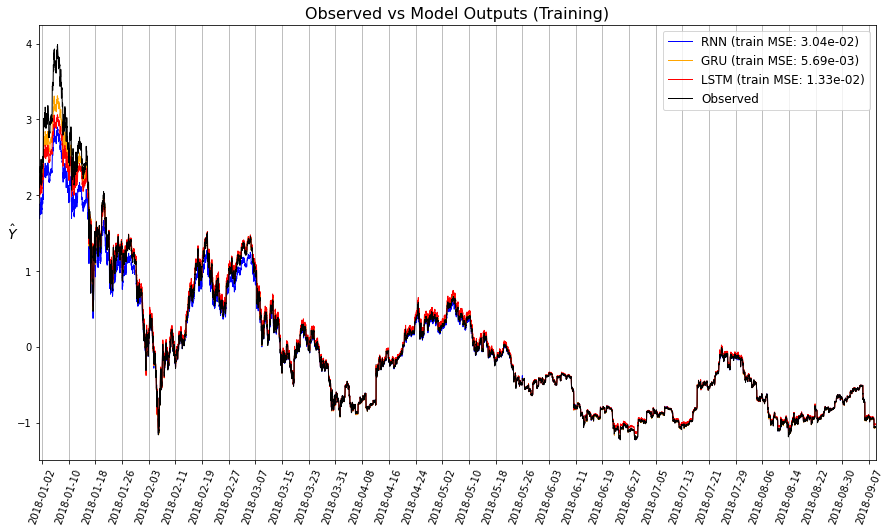

In [32]:
max_pts = 10**4
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable. 

fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_train[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Training)', fontsize=16);

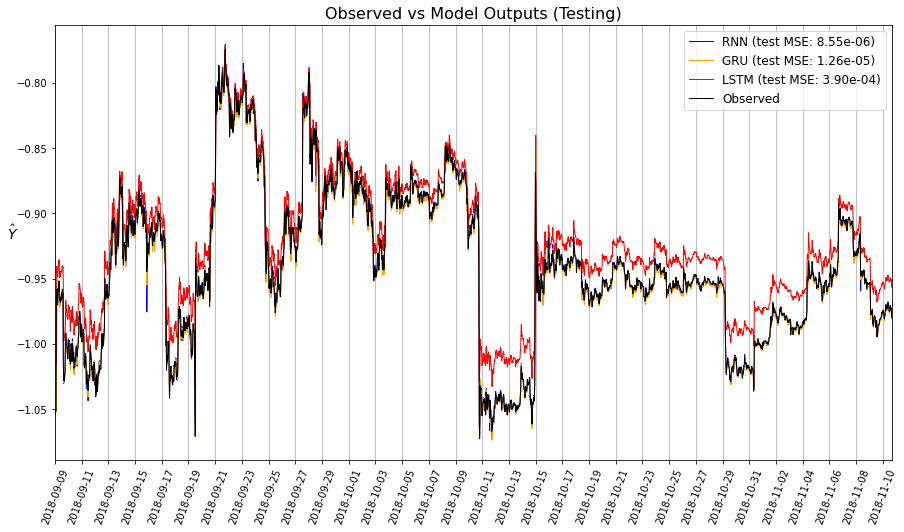

In [33]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
plt.plot(x_vals, y_test[l:u:ds], c="black", label="Observed", lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=70)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}$', rotation=0, fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Outputs (Testing)', fontsize=16);

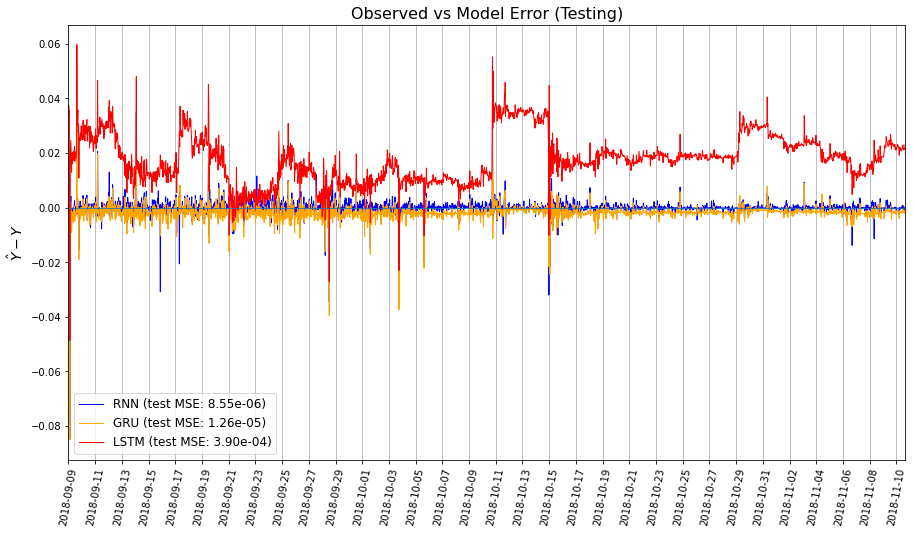

In [34]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # e.g. (None, 100000) lower and upper indices of range to plot 
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_test_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_test'][l:u:ds] - y_test[l:u:ds]
    label = params[key]['label'] + ' (test MSE: %.2e)' % params[key]['MSE_test']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Testing)', fontsize=16);

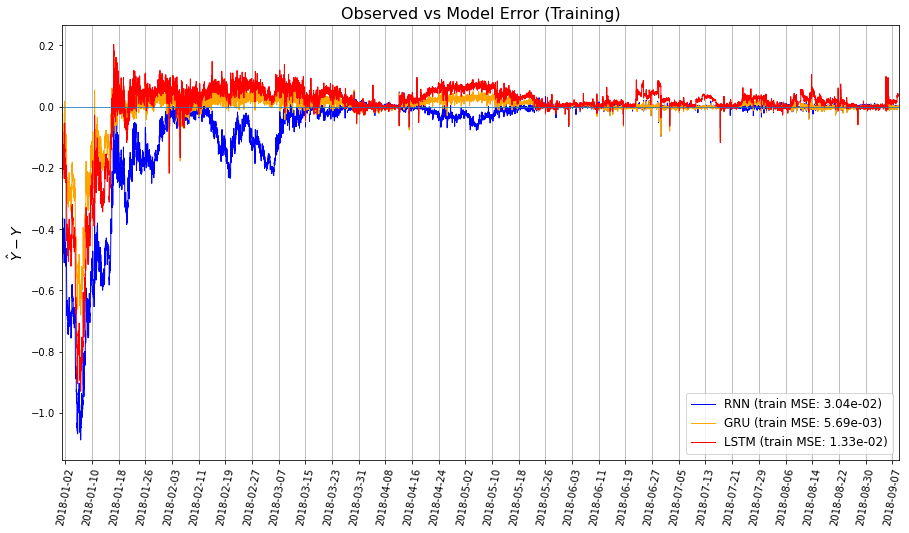

In [35]:
compare = params.keys() # e.g. ['rnn', 'alpharnn'] or ['lstm']
l, u = (None, None) # lower and upper indices of range to plot - e.g. (None, 10000)
ds = max(1, len(y_train[l:u])//max_pts) # Downsampling ratio for under `max_pts`
                                        # per series.  Set `None` to disable.
fig = plt.figure(figsize=(15,8))
x_vals = y_train_timestamps[l:u:ds]
for key in compare:
    y_vals = params[key]['pred_train'][l:u:ds] - y_train[l:u:ds]
    label = params[key]['label'] + ' (train MSE: %.2e)' % params[key]['MSE_train']
    plt.plot(x_vals, y_vals, c=params[key]['color'], label=label, lw=1)
start, end = x_vals.min(), x_vals.max()
xticks =  [start.date() + timedelta(days=(1+i)) for i in range(1 + (end - start).days)]
xticks = xticks[::max(1, len(xticks)//30)]
plt.axhline(0, linewidth=0.8)
for t in xticks: plt.axvline(x=t, c='gray', linewidth=0.5, zorder=0)
plt.xticks(xticks, rotation=80)
plt.xlim(start, end)
plt.ylabel('$\hat{Y}-Y$', fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.title('Observed vs Model Error (Training)', fontsize=16);

### Model Diagnostics

A fitted time series model must be examined for underfitting with a white noise test. We analyze the model residuals (i.e. the error $u_t$) to determine whether it is white noise or whether it is auto-correlated. The latter case provides statistical evidence that more lags are needed in the RNN. Box and Pierce propose the Portmanteau statistic:

$$Q^*(m)=T\sum_{l=1}^m\hat{\tau}_l^2,$$  
as a test statistic for the null hypothesis $H_0:\tau_1=\dots=\tau_m=0$ against the alternative hypothesis $H_a:\tau_i\neq 0$ for some $i\in\{1,\dots,m\}$, where $T$ is the number of observations, $\hat{\tau}_i$ are the sample autocorrelations of the residual, and $m$ is the maximum lag used in the test. There are several heuristics in the statistics literature to determine the maximum lag such as the Schwert statistic. 

The Box-Pierce statistic follows an asymptotically chi-squared distribution with $m$ degrees of freedom.

The Ljung-Box test statistic increases the power of the test in finite samples:
$$Q(m)=T(T+2)\sum_{l=1}^m\frac{\hat{\tau}_l^2}{T-l}$$
This statistic also follows an asymptotically chi-squared distribution with $m$ degrees of freedom. The decision rule is to reject $H_0$ if $Q(m)>\chi_{\alpha}^2$ where $\chi_{\alpha}^2$ denotes the $100(1-\alpha)^{th}$ percentile of a chi-squared distribution with m degrees of freedom and is the significance level for rejecting $H_0$.

The test can be time consuming and we select a subset of the residuals. Here we simply set the maximum lag to 20. In the results below, we find that the p-values are all smaller than 0.01, indicating that we can reject the null at the 99% confidence level for any lag. This is strong evidence that the model is under-fitting and more lags are needed in our model. Unlike an auto-regressive model, increasing the number of lags in the RNN does not increase the number of weights. Thus there is no danger of over-fitting by increasing the lag, although there will be an increase in the training time.

In [37]:
# number of samples to use for computing test statistic
n = 100000

In [38]:
params.keys()

dict_keys(['rnn', 'gru', 'lstm'])

In [39]:
key = 'rnn'
predicted = params[key]['pred_test']
residual = y_test[-n:] - predicted[-n:]

In [40]:
lb, p = sm.stats.diagnostic.acorr_ljungbox(residual, lags=20, boxpierce=False)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


The Box-Ljung test statistics are

In [41]:
lb

array([41323.36281507, 56320.93743004, 62475.17588081, 63241.91630807,
       64681.39529521, 65165.94094989, 65176.63441291, 65283.57734583,
       65369.84276076, 65393.92699065, 65394.04295178, 65410.56998868,
       65416.75449464, 65423.04330739, 65424.47825642, 65430.9650553 ,
       65449.43101314, 65456.79966071, 65463.02440391, 65466.25583511])

The p-values are

In [43]:
p

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])